# Référendum 2013

In [1]:
import psycopg2

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
from scipy import stats

In [5]:
import matplotlib.pyplot as plt

Running a Docker container with PostgreSQL 9.6 image

Data are ingested into the database.

In [6]:
saved = False

In [7]:
conn = psycopg2.connect(host='0.0.0.0', port='5433', dbname='postgres', user='postgres')

## Validation
(inscrits - absentions) == (blancs + choix_a + choix_b)

In [8]:
# Validating that the entry is equal.
validation = pd.read_sql('SELECT code_departement, name_commune, diff FROM (SELECT code_departement, name_commune, (inscrits - absentions) - (blancs + choix_a +choix_b) AS diff FROM referendum) AS a WHERE diff > 0', con=conn)

In [9]:
len(validation)

0

## Le taux de participation

In [10]:
gen_participation = pd.read_sql('SELECT SUM(inscrits) AS total_inscrits, SUM(absentions) AS total_absent, SUM(blancs) AS total_blancs, SUM(choix_a) AS total_choix_a, SUM(choix_b) AS total_choix_b FROM referendum_departement', con=conn)

In [11]:
taux_absents = gen_participation['total_absent']/gen_participation['total_inscrits']
taux_vote = 1.0 - taux_absents

In [12]:
def general_participation(labels, dataset, explode_pie, is_save, filename):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    explode = explode_pie  # only "explode" the 2nd slice
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    ax1.pie(dataset, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    if is_save:
        plt.savefig(filename, format='png')
    else:
        plt.show()

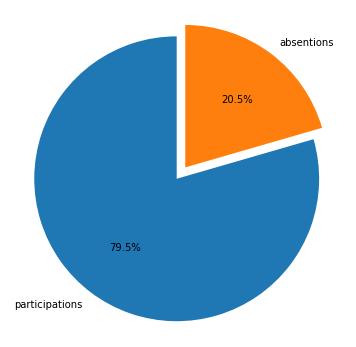

In [13]:
general_participation(['participations', 'absentions'], [taux_vote, taux_absents], (0, 0.1), saved, 'referendum_participation.png')

## Le resultat

In [14]:
general_choix = gen_participation['total_blancs'] + gen_participation['total_choix_a'] + gen_participation['total_choix_b']

In [15]:
choix_a = gen_participation['total_choix_a']/general_choix
choix_b = gen_participation['total_choix_b']/general_choix
blancs = gen_participation['total_blancs']/general_choix

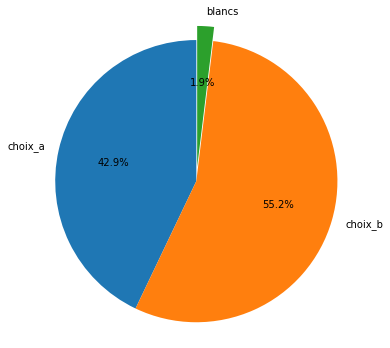

In [16]:
general_participation(['choix_a', 'choix_b', 'blancs'], [choix_a, choix_b, blancs], (0, 0, 0.1), saved, 'referendum_vote.png')

## Le taux de participation par departement

In [17]:
departement_participation = pd.read_sql('SELECT code_departement, name_departement, 1.0 - (absentions*1.0)/(inscrits*1.0) AS participation FROM referendum_departement ORDER BY participation DESC', con=conn)

In [18]:
def departement_vote(depart_partici_dataset, is_save, filename):
    ind = np.arange(len(depart_partici_dataset))
    fig1, ax1 = plt.subplots(figsize=(14, 14))
    bars = plt.bar(ind + 1.0, depart_partici_dataset['participation']*100.0)
    ax1.set_xticks(ind+ 1.0)
    ax1.set_ylim(0.0, 100.0)
    xtickNames = plt.setp(ax1, xticklabels=depart_partici_dataset['name_departement'])
    plt.setp(xtickNames, rotation=60, fontsize=12)
    if is_save:
        plt.savefig(filename, format='png')
    else:
        plt.show()

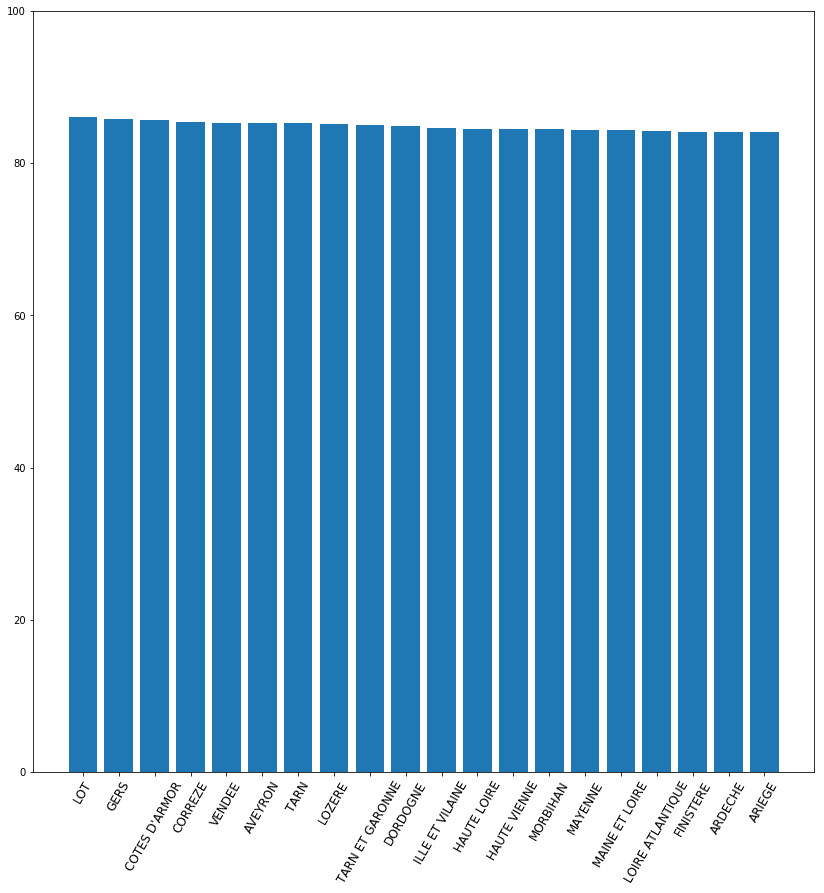

In [19]:
departement_vote(departement_participation.head(20), saved, 'participation_dep_head20.png')

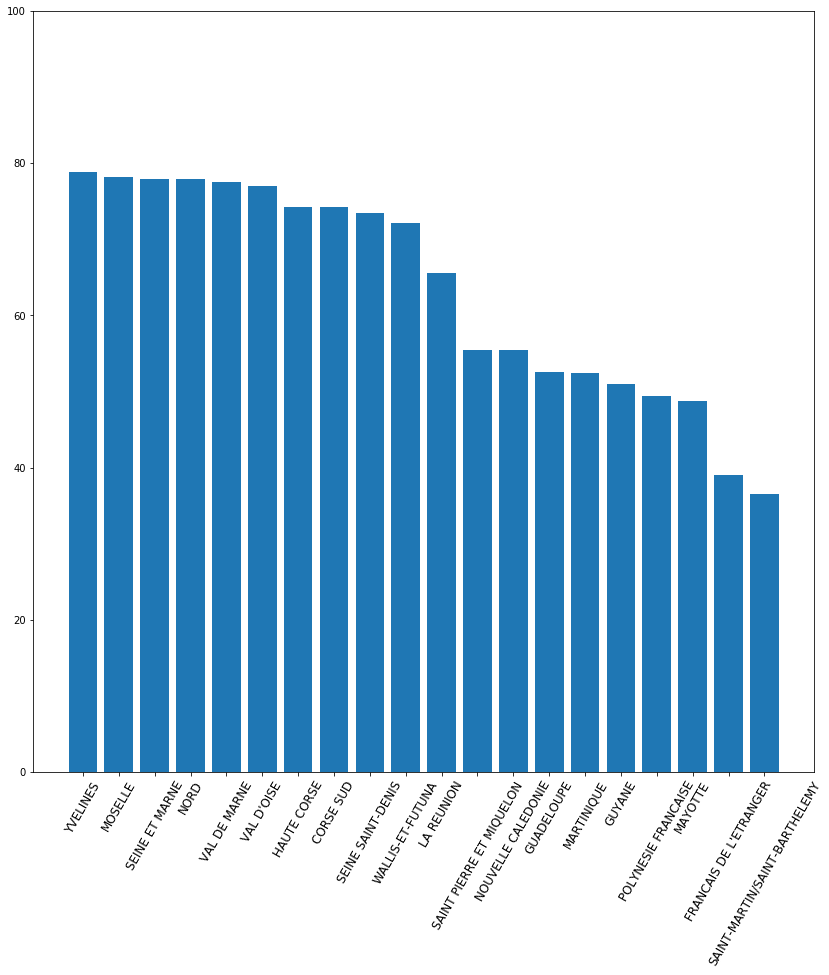

In [20]:
departement_vote(departement_participation.tail(20), saved, 'participation_dep_tail20.png')

## La distribution de vote

In [21]:
choix_data = pd.read_sql('SELECT code_departement, name_departement, blancs*1.0/(choix_a+choix_b+blancs)*1.0 AS perc_blancs, choix_a*1.0/(choix_a+choix_b+blancs)*1.0 AS perc_choix_a, choix_b*1.0/(choix_a+choix_b+blancs)*1.0 AS perc_choix_b FROM referendum_departement', con=conn)

In [22]:
def departement_choix_histogram(choix_dataset, is_save, filename):
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax1.set_title('Choix A')
    ax1.set_xlabel('Percentage')
    ax1.set_xlim(30.0, 70.0)
    ax1.set_ylabel('N of departement')
    ax1.hist(choix_dataset.perc_choix_a*100.0, bins=20)
    ax2 = fig.add_subplot(132)
    ax2.set_title('Choix B')
    ax2.set_xlabel('Percentage')
    ax2.set_xlim(30.0, 70.0)
    ax2.hist(choix_dataset.perc_choix_b*100.0, bins=20)
    ax3 = fig.add_subplot(133)
    ax3.set_title('Blancs et nul')
    ax3.set_xlabel('Percentage')
    ax3.hist(choix_dataset.perc_blancs*100.0, bins=20)
    ax3.set_xlim(0.0, 10.0)
    if is_save:
        plt.savefig(filename, format='png')
    else:
        plt.show()

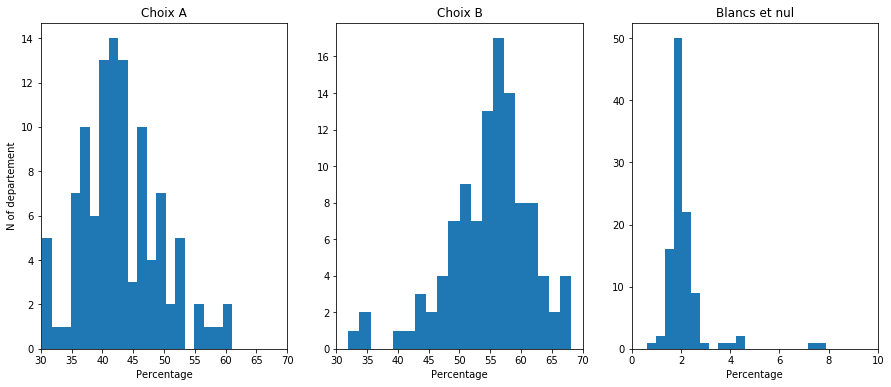

In [23]:
departement_choix_histogram(choix_data, saved, 'choix.png')

In [24]:
choix_data[choix_data.perc_blancs == choix_data.perc_blancs.max()]

,code_departement,name_departement,perc_blancs,perc_choix_a,perc_choix_b
66,ZB,MARTINIQUE,0.078771,0.56723,0.354


In [25]:
choix_data[choix_data.perc_blancs == choix_data.perc_blancs.min()]

,code_departement,name_departement,perc_blancs,perc_choix_a,perc_choix_b
104,ZW,WALLIS-ET-FUTUNA,0.00605,0.521098,0.472851


In [26]:
choix_data[choix_data.perc_choix_a == choix_data.perc_choix_a.max()]

,code_departement,name_departement,perc_blancs,perc_choix_a,perc_choix_b
55,ZD,LA REUNION,0.040336,0.610481,0.349183


In [27]:
choix_data[choix_data.perc_choix_a == choix_data.perc_choix_a.min()]

,code_departement,name_departement,perc_blancs,perc_choix_a,perc_choix_b
46,68,HAUT RHIN,0.020292,0.302237,0.677471


In [28]:
choix_data[choix_data.perc_choix_b == choix_data.perc_choix_b.max()]

,code_departement,name_departement,perc_blancs,perc_choix_a,perc_choix_b
4,6,ALPES MARITIMES,0.015312,0.303534,0.681155


In [29]:
choix_data[choix_data.perc_choix_b == choix_data.perc_choix_b.min()]

,code_departement,name_departement,perc_blancs,perc_choix_a,perc_choix_b
35,ZA,GUADELOUPE,0.072603,0.607968,0.319429


## L'index de choix

La Definition de l'index de choix,

    perc_choix_a = choix_a / (vote total)
    perc_choix_b = choix_b / (vote total)
    index = perc_choix_a - perc_choix_b

In [30]:
choix_index = pd.read_sql('SELECT code_departement, name_departement, perc_choix_a - perc_choix_b AS choix_index FROM referendum_choix_departement', con=conn)

In [31]:
# Define choix_index: choix_a - choix_b
def departement_choix_index_histogram(choix_dataset, is_save, filename):
    fig = plt.figure(figsize=(5, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title('Index Choix')
    ax1.set_xlabel('Choix_A% - Choix_B%')
    ax1.set_xlim(-0.50, 0.50)
    ax1.set_ylabel('N of departement')
    ax1.hist(choix_index.choix_index, bins=20)
    if is_save:
        plt.savefig(filename, format='png')
    else:
        plt.show()

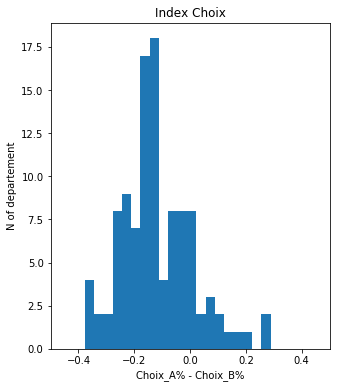

In [32]:
departement_choix_index_histogram(choix_index, saved, 'choix_index.png')

## Relation Participation - Vote (Index Choix)

In [33]:
data_vote_choix = pd.read_sql('SELECT a.code_departement, a.name_departement, (b.inscrits - b.absentions)*1.0/b.inscrits*1.0 AS perc_vote, a.perc_choix_a, a.perc_choix_b, a.perc_blancs, a.perc_choix_a - a.perc_choix_b AS choix_index FROM referendum_choix_departement AS a, referendum_departement AS b WHERE a.name_departement = b.name_departement', con=conn)

In [34]:
def plot_vote_choix_relation(data_vote_choix_dataset, is_save, filename):
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title('Relation Participation - idx_Choix')
    ax1.set_xlabel('Le taux de participation (%)')
    ax1.set_ylabel('Idx_Choix (Choix_A% - Choix_B%)')
    ax1.set_xlim(20.0, 100.0)
    ax1.set_ylim(-0.4, 0.4)
    ax1.scatter(data_vote_choix_dataset.perc_vote*100.0, data_vote_choix_dataset.choix_index, s=10.0)
    if is_save:
        plt.savefig(filename, format='png')
    else:
        plt.show()

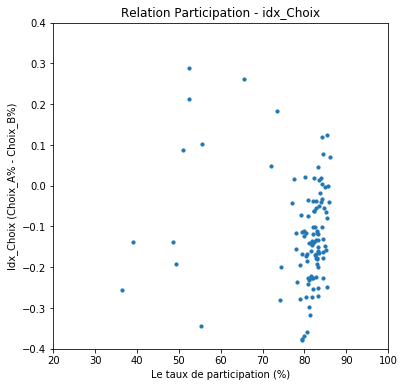

In [35]:
plot_vote_choix_relation(data_vote_choix, saved, 'relation_vote_choix_idx.png')

In [36]:
data_vote_choix[data_vote_choix['choix_index'] > 0.0].sort_values(by='choix_index')

,code_departement,name_departement,perc_vote,perc_choix_a,perc_choix_b,perc_blancs,choix_index
21,22,COTES D'ARMOR,0.857076,0.491030,0.490934,0.018036,0.000096
30,29,FINISTERE,0.841636,0.494002,0.489279,0.016719,0.004723
38,31,HAUTE GARONNE,0.834703,0.499144,0.484183,0.016673,0.014961
97,94,VAL DE MARNE,0.774994,0.499755,0.484273,0.015972,0.015483
22,23,CREUSE,0.822266,0.497709,0.478351,0.023940,0.019358
81,63,PUY DE DOME,0.840664,0.498989,0.479241,0.021771,0.019748
78,75,PARIS,0.801523,0.504291,0.483671,0.012038,0.020620
44,65,HAUTES PYRENEES,0.832350,0.512423,0.467472,0.020105,0.044951
104,ZW,WALLIS-ET-FUTUNA,0.721029,0.521098,0.472851,0.006050,0.048247
60,46,LOT,0.861383,0.524631,0.455015,0.020354,0.069615


## La relation de la population et du vote

On a utilsé les données d'évolution et structure de la population en 2013 (INSEE) et a selectionné: les hommes et les femmes qui ont >= 20 ans (P13_H2064, P13_H65P, P13_F2064, P13_F65P)

Les données sont mises au base de données.

In [37]:
# hors Mayotte
total_inscrits = pd.read_sql('SELECT SUM(inscrits) AS total_inscrits FROM referendum_departement WHERE name_departement != \'MAYOTTE\'', con=conn)

In [38]:
# hors Mayotte
total_adults = pd.read_sql('SELECT (SUM(a.homme_adu) + SUM(a.femme_adu)) AS total_adu FROM (SELECT code_departement, h2064+h65p AS homme_adu, f2064+f65p AS femme_adu FROM pop_departement_sum) AS a', con=conn)

In [39]:
total_inscrits['total_inscrits']/total_adults['total_adu']

0    0.9289
dtype: float64

### La relation du sexe et du vote

La definition de l'index de sexe

    perc_homme = homme / (population >= 20 ans)
    perc_femme = femme / (population >= 20 ans)
    idx_sexe = perc_homme - perc_femme

In [40]:
# La relation idx_Sexe - idx_Choix
c_s_data = pd.read_sql('SELECT * FROM choix_gendre_relation_dep', con=conn)

In [41]:
c_s_data.columns

Index(['code_departement', 'name_departement', 'choix_index', 'gender_index'], dtype='object')

In [42]:
def plot_choix_sexe_relation(choix_sexe_dataset, is_save, filename):
    slope, intercept, r_value, p_value, std_err = stats.linregress(choix_sexe_dataset.gender_index, choix_sexe_dataset.choix_index)
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title('Relation Sexe - Choix (France Métropolitaine)')
    ax1.set_xlabel('Homme - Femme (> 20 ans)')
    ax1.set_ylabel('Choix_A - Choix_B')
    ax1.set_xlim(-0.08, -0.01)
    ax1.set_ylim(-0.4, 0.2)
    ax1.scatter(choix_sexe_dataset.gender_index, choix_sexe_dataset.choix_index, s=10.0)
    plt.plot(choix_sexe_dataset.gender_index, intercept + slope*choix_sexe_dataset.gender_index, 'r', label='fitted line')
    if is_save:
        plt.savefig(filename, format='png')
    else:
        plt.show()

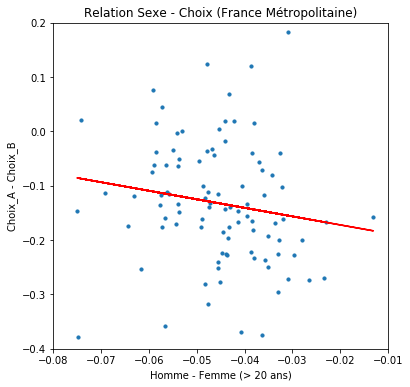

In [43]:
plot_choix_sexe_relation(c_s_data, saved, 'vote_tendency_by_gender.png')

In [44]:
slope, intercept, r_value, p_value, std_err = stats.linregress(c_s_data.gender_index, c_s_data.choix_index)

In [45]:
print(slope)

-1.57145982056


In [46]:
print(r_value**2)

0.0261746764737


In [47]:
print(p_value)

0.115302532224


In [48]:
print(std_err)

0.988642384349
